In [35]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

In [9]:
import json
import pandas as pd
import matplotlib.cm
import sqlite3
from colour import Color
def flatten(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [119]:
metadata = []
with open('scraped_metadata3/MasterMetadata3.txt','r') as f:
    for line in f:
        metadata.append(json.loads(line.strip()))
for item in metadata:
    item['categories'] = ', '.join(item['categories'].keys())
df = pd.DataFrame.from_dict(metadata)

In [138]:
# all ratings for business
dbfilename = 'scraped_reviews/SimilaritiesUnique.db'
Ratings = []
biz = 'El Farolito'
with sqlite3.connect(dbfilename) as conn:
    cursor = conn.cursor()
    cursor.execute("""
    select *
    from {0}
    where (business1 is "{1}" or business2 is "{1}") and revcount > 100
    order by diffscore asc
    """.format('similarities',biz))
    temp = cursor.fetchall()
    #for tt in range(0, len(temp)):
    #    Ratings.append(temp[tt][0])
names = [i2 for i1 in temp for i2 in i1 if (not i2 == biz and type(i2) is unicode)]
scores = [item[4] for item in temp]
commonreviews = [item[2] for item in temp]
colorInd = [int(255-round(255*(score - min(scores))/(max(scores) - min(scores)))) for score in scores]
colors = [Color(rgb=matplotlib.cm.Reds(ind)[:-1]).hex for ind in colorInd]
names.insert(0,biz)
scores.insert(0,0)
colors.insert(0,Color('blue').hex)
commonreviews.insert(0,0)

In [139]:
sims = []
for item in zip(names, scores, colors, commonreviews):
    sims.append(item)

In [140]:
simsdf = pd.DataFrame(sims, columns=['BizName','Score','Color', 'CommonReviews'])

In [141]:
dfm = simsdf.merge(df,on='BizName')

In [142]:
gjl = []
for ind, item in dfm.iterrows():
    gj = dict()
    gj['type'] = 'Feature'
    gj['geometry'] = {'type':'Point', 'coordinates':[item['longitude'],item['latitude']]}
    desc = 'Rating Differential: '+str(round(item['Score'],2))+',\nCategories: '+item['categories']
    gj['properties'] = {'title':item['BizName'], 'description' : desc, 'marker-color' : item['Color'], 
                        "marker-size": "medium"}
    gjl.append(gj)

In [143]:
with open('ElFarolitoSimilarities.geojson','w') as f:
    for line in json.dumps(gjl,indent=2, separators=(',', ': ')):
        f.write(line.encode('utf-8'))

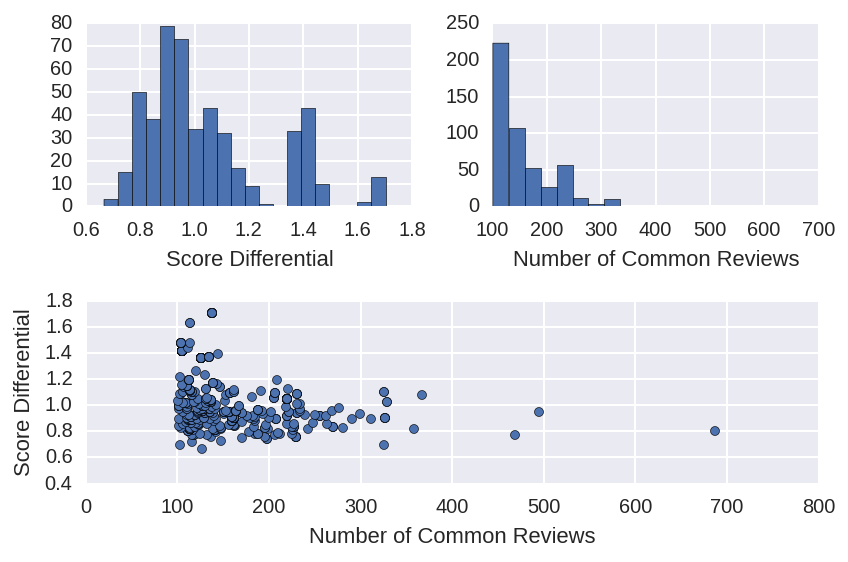

In [110]:
fig = plt.figure()

ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(212)
ax1.set_xlabel('Score Differential')
ax2.set_xlabel('Number of Common Reviews')

dfm[dfm['BizName'] != biz]['Score'].hist(bins=20, ax=ax1)
dfm[dfm['BizName'] != biz]['CommonReviews'].hist(bins=20, ax=ax2)
dfm[dfm['BizName'] != biz].plot(kind='scatter', x='CommonReviews', y='Score', ax=ax3)
ax3.set_xlabel('Number of Common Reviews')
ax3.set_ylabel('Score Differential')

plt.tight_layout()


In [123]:
gjl[-2]

{'geometry': {'coordinates': [-122.442636, 37.714307], 'type': 'Point'},
 'properties': {'description': u'Rating Differential: 1.70175438596\nCategories: Coffee & Tea, Asian Fusion, Bubble Tea',
  'marker-color': '#ffeee6',
  'marker-size': 'medium',
  'title': u'Quickly'},
 'type': 'Feature'}

In [126]:
sims[-1]

(u'Quickly', 1.70175438596, '#ffeee6', 138)

In [134]:
round(0.1234,2)

0.12

In [145]:
df[df['BizName'] == 'El Farolito']

,Accepts Apple Pay,Accepts Bitcoin,Accepts Credit Cards,Ages Allowed,Alcohol,Ambience,Attire,Best Nights,Bike Parking,BizName,...,Wi-Fi,categories,city,href,latitude,longitude,neighborhood,state,street address,zipcode
5484,NaN,NaN,Yes,NaN,Beer & Wine Only,Casual,Casual,NaN,Yes,El Farolito,...,No,Mexican,San Francisco,/biz/el-farolito-san-francisco,37.721131,-122.437161,Excelsior,CA,4817 Mission St,94112
5773,No,NaN,No,NaN,Beer & Wine Only,Divey,Casual,NaN,Yes,El Farolito,...,No,Mexican,San Francisco,/biz/el-farolito-san-francisco-2,37.752654,-122.418192,Mission,CA,2779 Mission St,94110


In [148]:
type(gjl[0])

dict

In [150]:
str(gjl[0:2])

"[{'geometry': {'type': 'Point', 'coordinates': [-122.4371614, 37.7211313]}, 'type': 'Feature', 'properties': {'marker-size': 'medium', 'marker-color': '#00f', 'description': u'Rating Differential: 0.0,\\nCategories: Mexican', 'title': 'El Farolito'}}, {'geometry': {'type': 'Point', 'coordinates': [-122.4181915, 37.752654]}, 'type': 'Feature', 'properties': {'marker-size': 'medium', 'marker-color': '#00f', 'description': u'Rating Differential: 0.0,\\nCategories: Mexican', 'title': 'El Farolito'}}]"

In [159]:
with sqlite3.connect(dbfilename) as conn:
    cursor = conn.cursor()
    cursor.execute("""
    select business1, business2, revcount, diffscore
    from {0}
    where revcount >= 100
    """.format('similarities'))
    temp = cursor.fetchall()
    #for tt in range(0, len(temp)):
    #    Ratings.append(temp[tt][0])

In [160]:
len(temp)

16037

In [161]:
simsdf = pd.DataFrame(temp, columns=['Biz1', 'Biz2' ,'ReviewCount', 'Score'])

In [122]:
dfmeta = df[['href','BizName','latitude','longitude','categories','city','zipcode']]

In [123]:
#simsdf.to_pickle('SimilaritiesDataFrame.pd')
dfmeta.to_pickle('MetaDataFrame.pd')

In [180]:
dfmetaload = pd.read_pickle('MetaDataFrame.pd')

In [222]:
bizentry = pd.DataFrame([['El Farolito', 0, 0.0, '', 1, 1,['a','b'],'1']], 
                        columns=['BizName' ,'ReviewCount', 'Score', 'href','latitude','longitude','categories','Color'])

In [ ]:
dfmeta

In [12]:
biz = 'El Farolito'
#simsdf[simsdf['Biz2'] == biz].append(simsdf[simsdf['Biz1'] == biz])
biz1 = simsdf[simsdf['Biz2'] == biz].drop(['Biz2'], axis=1)
biz1.columns = ['BizName', 'ReviewCount', 'Score']
biz2 = simsdf[simsdf['Biz1'] == biz].drop(['Biz1'], axis=1)
biz2.columns = ['BizName', 'ReviewCount', 'Score']
bizfinal = biz1.append(biz2)

scores = bizfinal['Score']
colorInd = [int(255-round(255*(score - min(scores))/(max(scores) - min(scores)))) for score in scores] # color index
colors = [Color(rgb=matplotlib.cm.Reds(ind)[:-1]).hex for ind in colorInd]
bizfinal['Color'] = colors

bizentry = pd.DataFrame([[biz, 0, 0.0, Color('blue').hex]], columns=['BizName' ,'ReviewCount', 'Score', 'Color'])
bizfinal = bizfinal.append(bizentry)
dfm = bizfinal.merge(dfmeta,on='BizName')
dfm

,BizName,ReviewCount,Score,Color,href,latitude,longitude,categories
0,15 Romolo,116,0.775862,#9a0c14,/biz/15-romolo-san-francisco,37.798191,-122.406346,"Tapas/Small Plates, Cocktail Bars"
1,900 Grayson,102,0.892157,#be151a,/biz/900-grayson-berkeley-2,37.855182,-122.292301,"Breakfast & Brunch, American (New), Burgers"
2,99 Chicken,111,1.009009,#de2b25,/biz/99-chicken-santa-clara,37.353077,-121.976925,"Korean, Chicken Wings"
3,ABC Bakery & Cafe,104,1.625000,#fee2d5,/biz/abc-bakery-and-cafe-san-francisco-2,37.753780,-122.490557,"Bakeries, Chinese"
4,ABC Bakery & Cafe,104,1.625000,#fee2d5,/biz/abc-bakery-and-cafe-san-mateo,37.564982,-122.322747,"Bakeries, Asian Fusion"
5,Absinthe Brasserie & Bar,200,0.900000,#c1161b,/biz/absinthe-brasserie-and-bar-san-francisco-2,37.776946,-122.422807,"Breakfast & Brunch, Bars, French"
6,Angeline’s Louisiana Kitchen,170,0.752941,#8e0912,/biz/angelines-louisiana-kitchen-berkeley,37.868245,-122.267549,"Cajun/Creole, Seafood, Southern"
7,Arizmendi Bakery,229,0.768559,#960b13,/biz/arizmendi-bakery-oakland,37.810689,-122.244811,"Bakeries, Coffee & Tea, Pizza"
8,Arizmendi Bakery,229,0.768559,#960b13,/biz/arizmendi-bakery-san-francisco,37.763388,-122.466499,"Bakeries, Pizza"
9,Arizmendi Bakery,229,0.768559,#960b13,/biz/arizmendi-bakery-san-rafael,37.973152,-122.526869,"Bakeries, Sandwiches, Pizza"


In [206]:
scores = dfm[dfm['BizName'] != biz]['Score']
colorInd = [int(255-round(255*(score - min(scores))/(max(scores) - min(scores)))) for score in scores] # color index
colors = [Color(rgb=matplotlib.cm.Reds(ind)[:-1]).hex for ind in colorInd]
dfm['Color'] = colors

In [209]:
dfm[dfm['BizName']=='El Farolito']

,BizName,ReviewCount,Score,href,latitude,longitude,categories,Color


In [221]:
bizentry = pd.DataFrame([['El Farolito', 0, 0.0, '', 1, 1,['a','b'],'1']], columns=['BizName' ,'ReviewCount', 'Score', 'href','latitude','longitude','categories','Color'])

,BizName,ReviewCount,Score,href,latitude,longitude,categories,Color
0,El Farolito,0,0,,1,1,"[a, b]",1


In [230]:
a = ["a","b","c"]

In [232]:
str(a).replace("'",'"')

'["a", "b", "c"]'

In [5]:
dfmeta = pd.read_pickle('MetaDataFrame.pd')
simsdf = pd.read_pickle('SimilaritiesDataFrame.pd')

In [16]:
bizfinal

,BizName,ReviewCount,Score,Color
1062,Angeline’s Louisiana Kitchen,170,0.900000,#f24734
1984,Bakesale Betty,202,0.792079,#cb181d
3248,Brazil Fresh Squeeze Cafe,107,0.626168,#6f020e
3604,Burma Superstar,231,0.887446,#f0402f
4462,Cheese Board Pizza,329,0.790274,#cb181d
4912,Chipotle Mexican Grill,105,1.314286,#fff4ef
6433,El Farolito,147,0.741497,#b61319
7675,Gary Danko,102,0.764706,#bf151b
8095,Gordo Taqueria,109,1.064220,#fc9777
8227,Great China,111,0.936937,#f75b40


In [130]:
bizlist = ['Wingstop', 'El Farolito', 'Top Dog']
bizlist = ['Top Dog']

b = False
bizfinal = None
for biz in bizlist:
    #simsdf[simsdf['Biz2'] == biz].append(simsdf[simsdf['Biz1'] == biz])
    biz1 = simsdf[simsdf['Biz2'] == biz].drop(['Biz2'], axis=1)
    biz1.columns = ['BizName', 'ReviewCount', 'Score']
    biz2 = simsdf[simsdf['Biz1'] == biz].drop(['Biz1'], axis=1)
    biz2.columns = ['BizName', 'ReviewCount', 'Score']
    if b:
        bizfinal = bizfinal.merge(biz1.append(biz2),on='BizName',how='outer')
    else:
        bizfinal = biz1.append(biz2)
        b = True

scores = bizfinal.filter(regex="Score")
reviewcounts = bizfinal.filter(regex="ReviewCount")
meanscore = scores.mean(axis=1)
bizfinal = bizfinal.drop(scores,axis=1)
bizfinal = bizfinal.drop(reviewcounts,axis=1)
bizfinal['Score'] = meanscore

scores = bizfinal['Score']
if len(scores) > 1:
    colorInd = [int(255-round(255*(score - min(scores))/(max(scores) - min(scores)))) for score in scores] # color index
    colors = [Color(rgb=matplotlib.cm.Reds(ind)[:-1]).hex for ind in colorInd]
else:
    colors = Color('red').hex
bizfinal['Color'] = colors

for biz in bizlist:
    if any(bizfinal['BizName'] == biz):
        bizfinal.loc[bizfinal['BizName']==biz,'Score'] = 0.0
        bizfinal.loc[bizfinal['BizName']==biz,'Color'] = Color('blue').hex
    else:
        bizentry = pd.DataFrame([[biz, 0.0, Color('blue').hex]], columns=['BizName' , 'Score', 'Color'])
        bizfinal = bizfinal.append(bizentry)
dfm = bizfinal.merge(dfmeta,on='BizName')


In [116]:
bizfinal

,BizName,Score,Color
1062,Angeline’s Louisiana Kitchen,0.900000,#f24734
1984,Bakesale Betty,0.792079,#cb181d
3248,Brazil Fresh Squeeze Cafe,0.626168,#6f020e
3604,Burma Superstar,0.887446,#f0402f
4462,Cheese Board Pizza,0.790274,#cb181d
4912,Chipotle Mexican Grill,1.314286,#fff4ef
6433,El Farolito,0.741497,#b61319
7675,Gary Danko,0.764706,#bf151b
8095,Gordo Taqueria,1.064220,#fc9777
8227,Great China,0.936937,#f75b40


In [50]:
scores = bizfinal.filter(regex="Score_")
reviewcounts = bizfinal.filter(regex="ReviewCount_")
meanscore = scores.mean(axis=1)
bizfinal['Score'] = meanscore
bizfinal = bizfinal.drop(scores,axis=1)
bizfinal = bizfinal.drop(reviewcounts,axis=1)

In [57]:
bizfinal.iloc[1]['Color'] = 1

/opt/conda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/lib/python2.7/site-packages/pandas/core/series.py:664: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc[key] = value


In [103]:
import urllib
url = 'Joanie%E2%80%99s%20Caf%C3%A9'
url = urllib.unquote(url)
bizlist = url.split('&')

In [96]:
bizlist[0].decode('utf-8')

u'Joanie\u2019s Caf\xe9'

In [97]:
bizlist

['Joanie\xe2\x80\x99s Caf\xc3\xa9']

In [104]:
for ind, item in enumerate(bizlist):
    bizlist[ind] = item.decode('utf-8')

In [106]:
bizlist

[u'Joanie\u2019s Caf\xe9']

In [109]:
any(dfmeta['BizName'] == u'Joanie\u2019s Caf\xe9'

True

In [121]:
df.columns

Index([      u'Accepts Apple Pay',         u'Accepts Bitcoin',
          u'Accepts Credit Cards',            u'Ages Allowed',
                       u'Alcohol',                u'Ambience',
                        u'Attire',             u'Best Nights',
                  u'Bike Parking',                 u'BizName',
           u'By Appointment Only',                  u'Caters',
                    u'Coat Check',                u'Delivery',
                  u'Dogs Allowed',              u'Drive-Thru',
                     u'Fri Close',                u'Fri Open',
                      u'Good For',        u'Good For Dancing',
               u'Good for Groups',           u'Good for Kids',
              u'Good for Working',              u'Happy Hour',
                u'Has Pool Table',                  u'Has TV',
       u'Health Inspection Score',               u'Mon Close',
                      u'Mon Open',                   u'Music',
                      u'NReviews',             u'Noise 

In [15]:
url = 'El Farolito&&Top Dog+city=Oakland&&San Francisco+categories=Breakfast & Brunch&&Pizza&&Mexican'
sections = url.split('+')
Restaurants = sections[0].split('&&')
filters = None
for sec in sections[1:]:
    key = sec.split('=')[0]
    value = sec.split('=')[1].split('&&')
    if filters:
        filters[key] = value
    else:
        filters = {key: value}
d = {'restaurants': Restaurants, 'filters':filters}

In [16]:
d

{'filters': {'categories': ['Breakfast & Brunch', 'Pizza', 'Mexican'],
  'city': ['Oakland', 'San Francisco']},
 'restaurants': ['El Farolito', 'Top Dog']}

In [207]:
include = [True] * len(dfm)
filters = d['filters']
for key in filters.keys():
    values = filters[key]
    for ind, row in enumerate(dfm[key]):
        if len(set(row.split(',')).intersection(set(values))) == 0:
            include[ind] = False
dfm[include]

,BizName,Score,Color,href,latitude,longitude,categories,city,zipcode,include
3,Burma Superstar,0.887446,#f0402f,/biz/burma-superstar-oakland-6,37.834770,-122.263077,Burmese,Oakland,94609,True
5,Burma Superstar,0.887446,#f0402f,/biz/burma-superstar-san-francisco-2,37.782831,-122.462555,Burmese,San Francisco,94118,True
7,Chipotle Mexican Grill,1.314286,#fff4ef,/biz/chipotle-mexican-grill-san-francisco-5,37.732506,-122.490071,"Mexican, Fast Food",San Francisco,94132,True
8,Chipotle Mexican Grill,1.314286,#fff4ef,/biz/chipotle-mexican-grill-oakland?search_key...,37.810818,-122.244769,"Mexican, Fast Food",Oakland,94610,True
11,Chipotle Mexican Grill,1.314286,#fff4ef,/biz/chipotle-mexican-grill-oakland-2,37.737912,-122.197430,"Mexican, Fast Food",Oakland,94621,True
41,Chipotle Mexican Grill,1.314286,#fff4ef,/biz/chipotle-mexican-grill-san-francisco-18,37.782151,-122.446084,Mexican,San Francisco,94118,True
49,El Farolito,0.741497,#b61319,/biz/el-farolito-san-francisco,37.721131,-122.437161,Mexican,San Francisco,94112,True
50,El Farolito,0.741497,#b61319,/biz/el-farolito-san-francisco-2,37.752654,-122.418192,Mexican,San Francisco,94110,True
53,Gordo Taqueria,1.064220,#fc9777,/biz/gordo-taqueria-san-francisco-3,37.780618,-122.478088,"Mexican, Fast Food",San Francisco,94121,True
99,Little Star Pizza,0.614679,#67000d,/biz/little-star-pizza-san-francisco,37.777548,-122.438007,Pizza,San Francisco,94117,True


In [204]:
dfm

,BizName,Score,Color,href,latitude,longitude,categories,city,zipcode,include
0,Angeline’s Louisiana Kitchen,0.900000,#f24734,/biz/angelines-louisiana-kitchen-berkeley,37.868245,-122.267549,"Cajun/Creole, Seafood, Southern",Berkeley,94704,False
1,Bakesale Betty,0.792079,#cb181d,/biz/bakesale-betty-oakland,37.837042,-122.262171,"Bakeries, American (Traditional), Sandwiches",Oakland,94609,True
2,Brazil Fresh Squeeze Cafe,0.626168,#6f020e,/biz/brazil-fresh-squeeze-cafe-berkeley,37.872553,-122.266746,Brazilian,Berkeley,94704,False
3,Burma Superstar,0.887446,#f0402f,/biz/burma-superstar-oakland-6,37.834770,-122.263077,Burmese,Oakland,94609,True
4,Burma Superstar,0.887446,#f0402f,/biz/burma-superstar-alameda-2,37.763719,-122.243477,Burmese,Alameda,94501,False
5,Burma Superstar,0.887446,#f0402f,/biz/burma-superstar-san-francisco-2,37.782831,-122.462555,Burmese,San Francisco,94118,True
6,Cheese Board Pizza,0.790274,#cb181d,/biz/cheese-board-pizza-berkeley,37.880019,-122.269444,Pizza,Berkeley,94709,False
7,Chipotle Mexican Grill,1.314286,#fff4ef,/biz/chipotle-mexican-grill-san-francisco-5,37.732506,-122.490071,"Mexican, Fast Food",San Francisco,94132,True
8,Chipotle Mexican Grill,1.314286,#fff4ef,/biz/chipotle-mexican-grill-oakland?search_key...,37.810818,-122.244769,"Mexican, Fast Food",Oakland,94610,True
9,Chipotle Mexican Grill,1.314286,#fff4ef,/biz/chipotle-mexican-grill-san-carlos-3?searc...,37.502155,-122.246290,"Mexican, Fast Food",San Carlos,94070,False


In [142]:
dfm

,BizName,Score,Color,href,latitude,longitude,categories,city,zipcode,include
0,Angeline’s Louisiana Kitchen,0.900000,#f24734,/biz/angelines-louisiana-kitchen-berkeley,37.868245,-122.267549,"Cajun/Creole, Seafood, Southern",Berkeley,94704,True
1,Bakesale Betty,0.792079,#cb181d,/biz/bakesale-betty-oakland,37.837042,-122.262171,"Bakeries, American (Traditional), Sandwiches",Oakland,94609,True
2,Brazil Fresh Squeeze Cafe,0.626168,#6f020e,/biz/brazil-fresh-squeeze-cafe-berkeley,37.872553,-122.266746,Brazilian,Berkeley,94704,True
3,Burma Superstar,0.887446,#f0402f,/biz/burma-superstar-oakland-6,37.834770,-122.263077,Burmese,Oakland,94609,True
4,Burma Superstar,0.887446,#f0402f,/biz/burma-superstar-alameda-2,37.763719,-122.243477,Burmese,Alameda,94501,True
5,Burma Superstar,0.887446,#f0402f,/biz/burma-superstar-san-francisco-2,37.782831,-122.462555,Burmese,San Francisco,94118,True
6,Cheese Board Pizza,0.790274,#cb181d,/biz/cheese-board-pizza-berkeley,37.880019,-122.269444,Pizza,Berkeley,94709,True
7,Chipotle Mexican Grill,1.314286,#fff4ef,/biz/chipotle-mexican-grill-san-francisco-5,37.732506,-122.490071,"Mexican, Fast Food",San Francisco,94132,True
8,Chipotle Mexican Grill,1.314286,#fff4ef,/biz/chipotle-mexican-grill-oakland?search_key...,37.810818,-122.244769,"Mexican, Fast Food",Oakland,94610,True
9,Chipotle Mexican Grill,1.314286,#fff4ef,/biz/chipotle-mexican-grill-san-carlos-3?searc...,37.502155,-122.246290,"Mexican, Fast Food",San Carlos,94070,True


In [198]:
temp = 'asdf, asdf, as, s'.split(',')
[item.strip() for item in temp]

['asdf', 'asdf', 'as', 's']

In [199]:
cats = []
for row in dfmeta['categories']:
    temp = row.split(',')
    cats.extend([item.strip() for item in temp])
sorted(list(set(cats)))

[u'Afghan',
 u'African',
 u'American (New)',
 u'American (Traditional)',
 u'Arabian',
 u'Argentine',
 u'Armenian',
 u'Art Galleries',
 u'Arts & Crafts',
 u'Asian Fusion',
 u'Austrian',
 u'Bagels',
 u'Bakeries',
 u'Barbeque',
 u'Bars',
 u'Basque',
 u'Bed & Breakfast',
 u'Beer',
 u'Beer Bar',
 u'Beer Gardens',
 u'Belgian',
 u'Bookstores',
 u'Bowling',
 u'Brasseries',
 u'Brazilian',
 u'Breakfast & Brunch',
 u'Breweries',
 u'British',
 u'Bubble Tea',
 u'Buffets',
 u'Burgers',
 u'Burmese',
 u'Butcher',
 u'Cafes',
 u'Cajun/Creole',
 u'Cambodian',
 u'Cantonese',
 u'Caribbean',
 u'Casinos',
 u'Caterers',
 u'Cheese Shops',
 u'Cheesesteaks',
 u'Chicken Shop',
 u'Chicken Wings',
 u'Chinese',
 u'Chocolatiers & Shops',
 u'Cinema',
 u'Cocktail Bars',
 u'Coffee & Tea',
 u'Colombian',
 u'Comedy Clubs',
 u'Comfort Food',
 u'Convenience Stores',
 u'Cooking Classes',
 u'Cooking Schools',
 u'Country Dance Halls',
 u'Creperies',
 u'Cuban',
 u'Czech',
 u'Dance Clubs',
 u'Delis',
 u'Desserts',
 u'Dim Sum',
 

In [11]:
dfmeta = pd.read_pickle('MetaDataFrame.pd')
simsdf = pd.read_pickle('SimilaritiesDataFrame.pd')
colors = ['#ffffff','#ffffcc','#ffeda0','#fed976','#feb24c','#fd8d3c','#fc4e2a','#e31a1c','#bd0026','#800026']

In [82]:
parsedURL = d
bizlist = parsedURL['restaurants']
filters = parsedURL['filters']
b = False
bizfinal = None
for biz in bizlist:
    #simsdf[simsdf['Biz2'] == biz].append(simsdf[simsdf['Biz1'] == biz])
    biz1 = simsdf[simsdf['Biz2'] == biz].drop(['Biz2'], axis=1)
    biz1.columns = ['BizName', 'ReviewCount', 'Score']
    biz2 = simsdf[simsdf['Biz1'] == biz].drop(['Biz1'], axis=1)
    biz2.columns = ['BizName', 'ReviewCount', 'Score']
    if b:
        bizfinal = bizfinal.merge(biz1.append(biz2),on='BizName',how='outer')
    else:
        bizfinal = biz1.append(biz2)
        b = True

scores = bizfinal.filter(regex="Score")
reviewcounts = bizfinal.filter(regex="ReviewCount")
meanscore = scores.mean(axis=1)
bizfinal = bizfinal.drop(scores,axis=1)
bizfinal = bizfinal.drop(reviewcounts,axis=1)
bizfinal['Score'] = meanscore

for biz in bizlist:
    if any(bizfinal['BizName'] == biz):
        bizfinal.loc[bizfinal['BizName']==biz,'Score'] = 0.0
    else:
        bizentry = pd.DataFrame([[biz, 0.0]], columns=['BizName' , 'Score'])
        bizfinal = bizfinal.append(bizentry)
dfm = bizfinal.merge(dfmeta,on='BizName')

if filters:
    include = [True] * len(dfm)
    for key in filters.keys():
        values = filters[key]
        for ind, row in enumerate(dfm[key]):
            if len(set(row.split(',')).intersection(set(values))) == 0:
                include[ind] = False
    dfm = dfm[include]

MeanScore = dfm[dfm['Score'] != 0]['Score'].mean()
StdScore = dfm[dfm['Score'] != 0]['Score'].std()
stdlims = [-2,2]

colors = ['#ffffcc','#ffeda0','#fed976','#feb24c','#fd8d3c','#fc4e2a','#e31a1c','#bd0026','#800026']
bins = [i/2.0-2 for i in range(8)]
zscore = (dfm['Score']-MeanScore)/StdScore
clist = []
for ind, item in enumerate(zscore):
    b = sum([1 if item > i else 0 for i in bins])
    clist.append(colors[b])
dfm['Color'] = clist
dfm.loc[dfm['Score']==0.0,'Color'] = Color('blue').hex


In [80]:
dfm

,BizName,Score,href,latitude,longitude,categories,city,zipcode,Color
5,Absinthe Brasserie & Bar,0.900000,/biz/absinthe-brasserie-and-bar-san-francisco-2,37.776946,-122.422807,"Breakfast & Brunch, Bars, French",San Francisco,94102,#fed976
57,Butler & The Chef Bistro,0.959016,/biz/butler-and-the-chef-bistro-san-francisco,37.780898,-122.394214,"Breakfast & Brunch, French",San Francisco,94107,#feb24c
64,Chipotle Mexican Grill,1.365934,/biz/chipotle-mexican-grill-san-francisco-5,37.732506,-122.490071,"Mexican, Fast Food",San Francisco,94132,#800026
65,Chipotle Mexican Grill,1.365934,/biz/chipotle-mexican-grill-oakland?search_key...,37.810818,-122.244769,"Mexican, Fast Food",Oakland,94610,#800026
68,Chipotle Mexican Grill,1.365934,/biz/chipotle-mexican-grill-oakland-2,37.737912,-122.197430,"Mexican, Fast Food",Oakland,94621,#800026
98,Chipotle Mexican Grill,1.365934,/biz/chipotle-mexican-grill-san-francisco-18,37.782151,-122.446084,Mexican,San Francisco,94118,#800026
110,Crepevine,0.898551,/biz/crepevine-oakland,37.843448,-122.251480,"Breakfast & Brunch, Creperies, American (New)",Oakland,94618,#fed976
112,Crepevine,0.898551,/biz/crepevine-san-francisco,37.764346,-122.464710,"Breakfast & Brunch, Creperies, American (New)",San Francisco,94122,#fed976
131,Papalote Mexican Grill,1.079019,/biz/papalote-mexican-grill-san-francisco-2,37.775720,-122.445979,Mexican,San Francisco,94117,#fc4e2a
132,Papalote Mexican Grill,1.079019,/biz/papalote-mexican-grill-san-francisco,37.751978,-122.421030,Mexican,San Francisco,94110,#fc4e2a


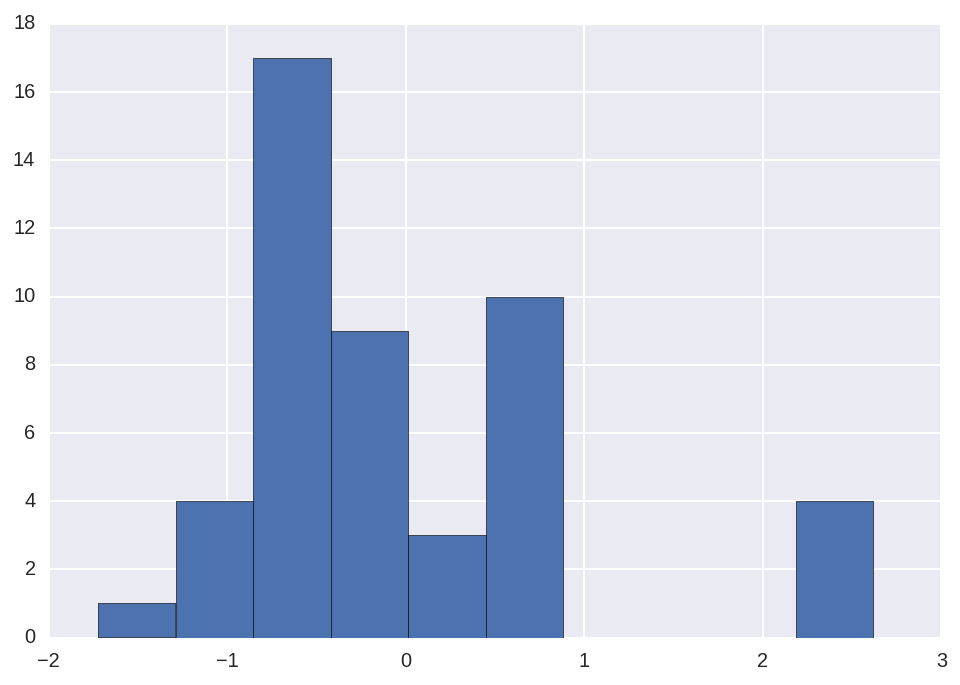

In [36]:
((dfm[dfm['Score'] != 0]['Score']-MeanScore)/StdScore).hist()

In [83]:
bins = [i/2.0-2 for i in range(8)]
bins

[-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5]

In [64]:
temp = (dfm[dfm['Score'] != 0]['Score']-MeanScore)/StdScore
temp = [-2.1, -1.9, -1.4, -0.9,-0.4, 0.1,0.6,1.1,1.6,1.9,2.1]
for item in temp:
    print item, sum([1 if item > i else 0 for i in bins])

-2.1 0
-1.9 1
-1.4 2
-0.9 3
-0.4 4
0.1 5
0.6 6
1.1 7
1.6 8
1.9 8
2.1 9


In [62]:
sum([1 if temp.iloc[1] > i else 0 for i in bins])

4